## Planet four image classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import sklearn.metrics as metrics
import tqdm

from torch.utils.data import DataLoader
from torchvision.datasets.folder import pil_loader
from pathlib import Path
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change the device to "cpu" if you want to train on a CPU instead of a GPU.

In [3]:
device = 'cuda'

## Dataset

Here we define a custom Dataset object for the Planet Four data. You can read more about this in the PyTorch documentation: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [4]:
class PlanetFourDataset(object):
    def __init__(self, split='train', transform=None, loader=pil_loader):
        super().__init__()
        self.split = split
        self.base_dir = Path('/content/drive/MyDrive/Splits')
        self.image_dir = self.base_dir / split
        self.labels_file = self.base_dir / (split + '.csv')
        self.labels_df = pd.read_csv(self.labels_file)
        self.transform = transform
        self.loader = loader
        
    def __getitem__(self, index):
        row = self.labels_df.iloc[index]
        filename = self.image_dir / (row.tile_id + '.jpg')
        fans = int(row.fans)
        blotches = int(row.blotches)
        image = self.loader(str(filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.tensor([fans, blotches], dtype=torch.float32)
    
    def __len__(self):
        return len(self.labels_df)

## Data augmentation

It is standard practice in deep learning to augment the training examples to prevent the network from overfitting. Here I use some standard augmentations such as randomly mirroring the images.

In [5]:
train_transform = transforms.Compose([                                 
    transforms.RandomHorizontalFlip(p=0.9),
    transforms.RandomRotation(degrees=180),
    transforms.CenterCrop((200,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))                  
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])

## Data loaders

In PyTorch, the data loaders take care of spinning up threads to load batches of data into memory from the dataset object.

In [6]:
train_set = PlanetFourDataset('train', transform=train_transform)
valid_set = PlanetFourDataset('valid', transform=train_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)

## Load a pretrained model

Here we'll use ResNet50 model that has been pretrained on ImageNet and replace the final layer with a new one suited to our problem.

In [7]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048,2)
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Loss

Images can contain fans, blotches, both, or neither. You could treat this as a four class softmax problem, or two binary classification problems. Here I take the latter approach and use a binary cross entropy loss. 

In [8]:
criterion = nn.BCEWithLogitsLoss()

## Optimizer

Stochastic gradient descent with momentum

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

## Training and validation functions

In [11]:
avg_train_losses = []
avg_valid_losses = []
valid_accuracies = []


def train_for_epoch(optimizer):
    model.train()

    train_losses = []

    for batch, target in tqdm.tqdm(train_loader):

        # data to GPU
        batch = batch.to(device)
        target = target.to(device)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        predictions = model(batch)
        #breakpoint()

        # calculate loss
        loss = criterion(predictions, target)

        # backward pass
        loss.backward()

        # parameter update
        optimizer.step()

        # track loss
        train_losses.append(float(loss.item()))

    train_losses = np.array(train_losses)
    return train_losses


def validate():
    model.eval()

    valid_losses = []
    y_true, y_prob = [], []

    with torch.no_grad():
        for batch, target in valid_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)
            
            # logits -> probabilities
            torch.sigmoid_(predictions)

            # track losses and predictions
            valid_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_prob.extend(predictions.cpu().numpy())
            
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = y_prob > 0.5
    valid_losses = np.array(valid_losses)

    # calculate validation accuracy from y_true and y_pred
    fan_accuracy = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    blotch_accuracy = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    exact_accuracy = np.all(y_true == y_pred, axis=1).mean()

    # calculate the mean validation loss
    valid_loss = valid_losses.mean()

    return valid_loss, fan_accuracy, blotch_accuracy, exact_accuracy


def train(epochs, first_epoch=1):
    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, fan_accuracy, blotch_accuracy, both_accuracy = validate()
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  ',
              f'fan acc: {fan_accuracy:0.04f}  ',
              f'blotch acc: {blotch_accuracy:0.04f}  ',
              f'both acc: {both_accuracy:0.04f}'
        )
        
        # update learning curves
        avg_train_losses.append(train_loss.mean())
        avg_valid_losses.append(valid_loss)
        valid_accuracies.append((fan_accuracy, blotch_accuracy, both_accuracy))
        
        # save checkpoint
        torch.save(model, f'/content/drive/MyDrive/Models/res_sgd.pkl')

## Constant classifier accuracy

Evaluate how accurate would a $f(x) = \text{"most common class"}$ classifier be? 

In [12]:
def constant_clf_accuracy():
    y_true, y_pred = [], []
    with torch.no_grad():
        for _, target in valid_loader:
            y_true.extend(target.cpu().numpy())
            y_pred.extend(np.ones((target.shape[0], 2), dtype=np.float32))
            
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
        
    # calculate validation accuracy from y_true and y_pred
    f = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    b = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    t = np.all(y_true == y_pred, axis=1).mean()
    print(f'fan: {f}  blotch: {b}  both: {t}')

In [13]:
constant_clf_accuracy()

fan: 0.6218644702358667  blotch: 0.8083114938225384  both: 0.4399101460127293


## Train the model
Call the ``train(n)`` function to train for ``n`` epochs.

In [15]:
train(15)

100%|██████████| 752/752 [1:38:36<00:00,  7.87s/it]


[01] train loss: 0.5013  valid loss: 0.4573   fan acc: 0.7499   blotch acc: 0.8177   both acc: 0.6069


100%|██████████| 752/752 [05:44<00:00,  2.18it/s]


[02] train loss: 0.4521  valid loss: 0.4287   fan acc: 0.7697   blotch acc: 0.8289   both acc: 0.6350


100%|██████████| 752/752 [05:44<00:00,  2.18it/s]


[03] train loss: 0.4273  valid loss: 0.4198   fan acc: 0.7769   blotch acc: 0.8349   both acc: 0.6402


100%|██████████| 752/752 [05:44<00:00,  2.19it/s]


[04] train loss: 0.4150  valid loss: 0.4138   fan acc: 0.7900   blotch acc: 0.8293   both acc: 0.6492


100%|██████████| 752/752 [05:44<00:00,  2.19it/s]


[05] train loss: 0.4044  valid loss: 0.4093   fan acc: 0.7851   blotch acc: 0.8345   both acc: 0.6582


100%|██████████| 752/752 [05:43<00:00,  2.19it/s]


[06] train loss: 0.3946  valid loss: 0.3954   fan acc: 0.7982   blotch acc: 0.8326   both acc: 0.6612


100%|██████████| 752/752 [05:43<00:00,  2.19it/s]


[07] train loss: 0.3868  valid loss: 0.3964   fan acc: 0.8049   blotch acc: 0.8349   both acc: 0.6657


100%|██████████| 752/752 [05:44<00:00,  2.18it/s]


[08] train loss: 0.3819  valid loss: 0.3967   fan acc: 0.8019   blotch acc: 0.8319   both acc: 0.6694


100%|██████████| 752/752 [05:44<00:00,  2.18it/s]


[09] train loss: 0.3776  valid loss: 0.3899   fan acc: 0.7997   blotch acc: 0.8409   both acc: 0.6732


100%|██████████| 752/752 [05:44<00:00,  2.18it/s]


[10] train loss: 0.3715  valid loss: 0.3912   fan acc: 0.8034   blotch acc: 0.8386   both acc: 0.6717


100%|██████████| 752/752 [05:43<00:00,  2.19it/s]


[11] train loss: 0.3668  valid loss: 0.3865   fan acc: 0.8038   blotch acc: 0.8446   both acc: 0.6803


100%|██████████| 752/752 [05:43<00:00,  2.19it/s]


[12] train loss: 0.3625  valid loss: 0.3935   fan acc: 0.8049   blotch acc: 0.8353   both acc: 0.6717


100%|██████████| 752/752 [05:44<00:00,  2.18it/s]


[13] train loss: 0.3590  valid loss: 0.3847   fan acc: 0.8083   blotch acc: 0.8383   both acc: 0.6739


100%|██████████| 752/752 [05:43<00:00,  2.19it/s]


[14] train loss: 0.3543  valid loss: 0.3921   fan acc: 0.8087   blotch acc: 0.8435   both acc: 0.6851


100%|██████████| 752/752 [05:44<00:00,  2.19it/s]


[15] train loss: 0.3525  valid loss: 0.3832   fan acc: 0.8117   blotch acc: 0.8390   both acc: 0.6803


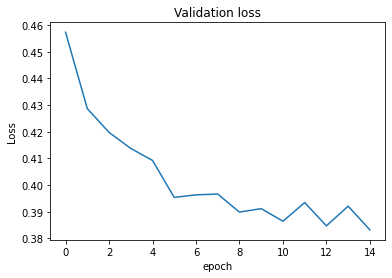

In [16]:
plt.plot(avg_valid_losses)
plt.title('Validation loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

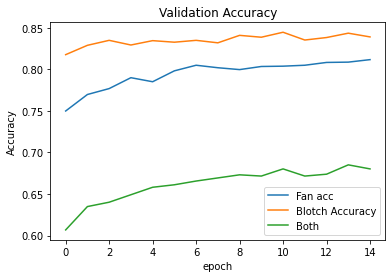

In [17]:
plt.plot(valid_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(["Fan acc","Blotch Accuracy","Both"])
plt.show()

EXPERIMENT WITH DIFFERENT NETWORK ARCHITECTURES

Alexnet Network

In [ ]:
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096,2)
model.to(device);

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [ ]:
avg_train_losses = []
avg_valid_losses = []
valid_accuracies = []


def train_for_epoch(optimizer):
    model.train()

    train_losses = []

    for batch, target in tqdm.tqdm(train_loader):

        # data to GPU
        batch = batch.to(device)
        target = target.to(device)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        predictions = model(batch)
        #breakpoint()

        # calculate loss
        loss = criterion(predictions, target)

        # backward pass
        loss.backward()

        # parameter update
        optimizer.step()

        # track loss
        train_losses.append(float(loss.item()))

    train_losses = np.array(train_losses)
    return train_losses


def validate():
    model.eval()

    valid_losses = []
    y_true, y_prob = [], []

    with torch.no_grad():
        for batch, target in valid_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)
            
            # logits -> probabilities
            torch.sigmoid_(predictions)

            # track losses and predictions
            valid_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_prob.extend(predictions.cpu().numpy())
            
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = y_prob > 0.5
    valid_losses = np.array(valid_losses)

    # calculate validation accuracy from y_true and y_pred
    fan_accuracy = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    blotch_accuracy = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    exact_accuracy = np.all(y_true == y_pred, axis=1).mean()

    # calculate the mean validation loss
    valid_loss = valid_losses.mean()

    return valid_loss, fan_accuracy, blotch_accuracy, exact_accuracy


def train(epochs, first_epoch=1):
    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, fan_accuracy, blotch_accuracy, both_accuracy = validate()
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  ',
              f'fan acc: {fan_accuracy:0.04f}  ',
              f'blotch acc: {blotch_accuracy:0.04f}  ',
              f'both acc: {both_accuracy:0.04f}'
        )
        
        # update learning curves
        avg_train_losses.append(train_loss.mean())
        avg_valid_losses.append(valid_loss)
        valid_accuracies.append((fan_accuracy, blotch_accuracy, both_accuracy))
        
        # save checkpoint
        torch.save(model, f'/content/drive/MyDrive/Models/alexnet.pkl')

In [ ]:
train(5)

100%|██████████| 752/752 [01:51<00:00,  6.73it/s]


[01] train loss: 0.4951  valid loss: 0.4643   fan acc: 0.7473   blotch acc: 0.8151   both acc: 0.5934


100%|██████████| 752/752 [01:51<00:00,  6.73it/s]


[02] train loss: 0.4528  valid loss: 0.4425   fan acc: 0.7660   blotch acc: 0.8210   both acc: 0.6237


100%|██████████| 752/752 [01:50<00:00,  6.80it/s]


[03] train loss: 0.4329  valid loss: 0.4347   fan acc: 0.7668   blotch acc: 0.8244   both acc: 0.6230


100%|██████████| 752/752 [01:51<00:00,  6.74it/s]


[04] train loss: 0.4192  valid loss: 0.4267   fan acc: 0.7694   blotch acc: 0.8255   both acc: 0.6331


100%|██████████| 752/752 [01:50<00:00,  6.80it/s]


[05] train loss: 0.4081  valid loss: 0.4253   fan acc: 0.7881   blotch acc: 0.8218   both acc: 0.6398


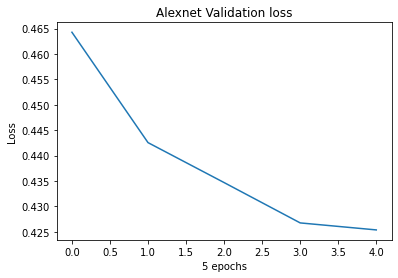

In [ ]:
plt.plot(avg_valid_losses)
plt.title('Alexnet Validation loss')
plt.xlabel('5 epochs')
plt.ylabel('Loss')
plt.show()

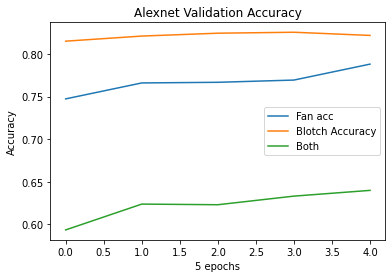

In [ ]:
plt.plot(valid_accuracies)
plt.title('Alexnet Validation Accuracy')
plt.xlabel('5 epochs')
plt.ylabel('Accuracy')
plt.legend(["Fan acc","Blotch Accuracy","Both"])
plt.show()

Changing Optimizer to Adam for Alexnet

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [18]:
avg_train_losses = []
avg_valid_losses = []
valid_accuracies = []


def train_for_epoch(optimizer):
    model.train()

    train_losses = []

    for batch, target in tqdm.tqdm(train_loader):

        # data to GPU
        batch = batch.to(device)
        target = target.to(device)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        predictions = model(batch)
        #breakpoint()

        # calculate loss
        loss = criterion(predictions, target)

        # backward pass
        loss.backward()

        # parameter update
        optimizer.step()

        # track loss
        train_losses.append(float(loss.item()))

    train_losses = np.array(train_losses)
    return train_losses


def validate():
    model.eval()

    valid_losses = []
    y_true, y_prob = [], []

    with torch.no_grad():
        for batch, target in valid_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)
            
            # logits -> probabilities
            torch.sigmoid_(predictions)

            # track losses and predictions
            valid_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_prob.extend(predictions.cpu().numpy())
            
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = y_prob > 0.5
    valid_losses = np.array(valid_losses)

    # calculate validation accuracy from y_true and y_pred
    fan_accuracy = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    blotch_accuracy = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    exact_accuracy = np.all(y_true == y_pred, axis=1).mean()

    # calculate the mean validation loss
    valid_loss = valid_losses.mean()

    return valid_loss, fan_accuracy, blotch_accuracy, exact_accuracy


def train(epochs, first_epoch=1):
    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, fan_accuracy, blotch_accuracy, both_accuracy = validate()
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  ',
              f'fan acc: {fan_accuracy:0.04f}  ',
              f'blotch acc: {blotch_accuracy:0.04f}  ',
              f'both acc: {both_accuracy:0.04f}'
        )
        
        # update learning curves
        avg_train_losses.append(train_loss.mean())
        avg_valid_losses.append(valid_loss)
        valid_accuracies.append((fan_accuracy, blotch_accuracy, both_accuracy))
        
        # save checkpoint
        torch.save(model, f'/content/drive/MyDrive/Models/alexnet_adam.pkl')

In [19]:
train(5)

100%|██████████| 752/752 [05:44<00:00,  2.18it/s]


[01] train loss: 0.3457  valid loss: 0.3905   fan acc: 0.8004   blotch acc: 0.8379   both acc: 0.6702


100%|██████████| 752/752 [05:44<00:00,  2.18it/s]


[02] train loss: 0.3436  valid loss: 0.3810   fan acc: 0.8165   blotch acc: 0.8353   both acc: 0.6836


100%|██████████| 752/752 [05:43<00:00,  2.19it/s]


[03] train loss: 0.3402  valid loss: 0.3967   fan acc: 0.8098   blotch acc: 0.8323   both acc: 0.6728


100%|██████████| 752/752 [05:43<00:00,  2.19it/s]


[04] train loss: 0.3379  valid loss: 0.3832   fan acc: 0.8087   blotch acc: 0.8383   both acc: 0.6762


100%|██████████| 752/752 [05:41<00:00,  2.20it/s]


[05] train loss: 0.3326  valid loss: 0.3929   fan acc: 0.8143   blotch acc: 0.8345   both acc: 0.6795


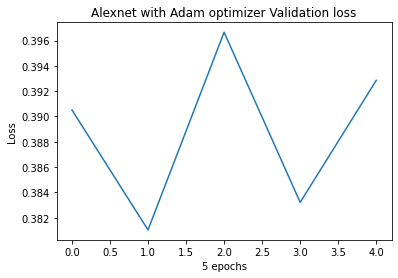

In [22]:
plt.plot(avg_valid_losses)
plt.title('Alexnet with Adam optimizer Validation loss')
plt.xlabel('5 epochs')
plt.ylabel('Loss')
plt.show()

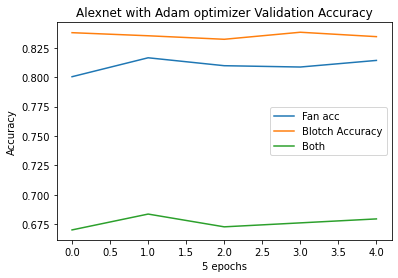

In [23]:
plt.plot(valid_accuracies)
plt.title('Alexnet with Adam optimizer Validation Accuracy')
plt.xlabel('5 epochs')
plt.ylabel('Accuracy')
plt.legend(["Fan acc","Blotch Accuracy","Both"])
plt.show()

Changing the learning rate of the Adam optimizer for Alexnet

In [33]:
criterion = nn.BCEWithLogitsLoss()

In [34]:
optimizer = optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-4)

In [35]:
avg_train_losses = []
avg_valid_losses = []
valid_accuracies = []


def train_for_epoch(optimizer):
    model.train()

    train_losses = []

    for batch, target in tqdm.tqdm(train_loader):

        # data to GPU
        batch = batch.to(device)
        target = target.to(device)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        predictions = model(batch)
        #breakpoint()

        # calculate loss
        loss = criterion(predictions, target)

        # backward pass
        loss.backward()

        # parameter update
        optimizer.step()

        # track loss
        train_losses.append(float(loss.item()))

    train_losses = np.array(train_losses)
    return train_losses


def validate():
    model.eval()

    valid_losses = []
    y_true, y_prob = [], []

    with torch.no_grad():
        for batch, target in valid_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)
            
            # logits -> probabilities
            torch.sigmoid_(predictions)

            # track losses and predictions
            valid_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_prob.extend(predictions.cpu().numpy())
            
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = y_prob > 0.5
    valid_losses = np.array(valid_losses)

    # calculate validation accuracy from y_true and y_pred
    fan_accuracy = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    blotch_accuracy = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    exact_accuracy = np.all(y_true == y_pred, axis=1).mean()

    # calculate the mean validation loss
    valid_loss = valid_losses.mean()

    return valid_loss, fan_accuracy, blotch_accuracy, exact_accuracy


def train(epochs, first_epoch=1):
    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, fan_accuracy, blotch_accuracy, both_accuracy = validate()
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  ',
              f'fan acc: {fan_accuracy:0.04f}  ',
              f'blotch acc: {blotch_accuracy:0.04f}  ',
              f'both acc: {both_accuracy:0.04f}'
        )
        
        # update learning curves
        avg_train_losses.append(train_loss.mean())
        avg_valid_losses.append(valid_loss)
        valid_accuracies.append((fan_accuracy, blotch_accuracy, both_accuracy))
        
        # save checkpoint
        torch.save(model, f'/content/drive/MyDrive/Models/alexnet_adam_0.05')

In [36]:
train(5)

100%|██████████| 752/752 [05:40<00:00,  2.21it/s]


[01] train loss: 0.6262  valid loss: 35.6842   fan acc: 0.3781   blotch acc: 0.8083   both acc: 0.3684


100%|██████████| 752/752 [05:40<00:00,  2.21it/s]


[02] train loss: 0.5900  valid loss: 0.5769   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 752/752 [05:40<00:00,  2.21it/s]


[03] train loss: 0.5887  valid loss: 2.7187   fan acc: 0.3781   blotch acc: 0.8083   both acc: 0.3684


100%|██████████| 752/752 [05:40<00:00,  2.21it/s]


[04] train loss: 0.5917  valid loss: 1.8694   fan acc: 0.3781   blotch acc: 0.8083   both acc: 0.3684


100%|██████████| 752/752 [05:39<00:00,  2.21it/s]


[05] train loss: 0.5947  valid loss: 0.7893   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


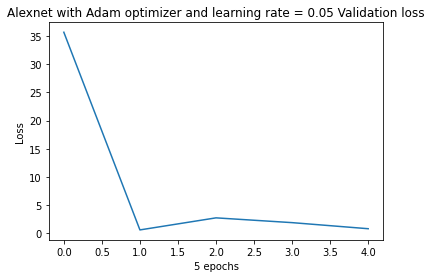

In [37]:
plt.plot(avg_valid_losses)
plt.title('Alexnet with Adam optimizer and learning rate = 0.05 Validation loss')
plt.xlabel('5 epochs')
plt.ylabel('Loss')
plt.show()

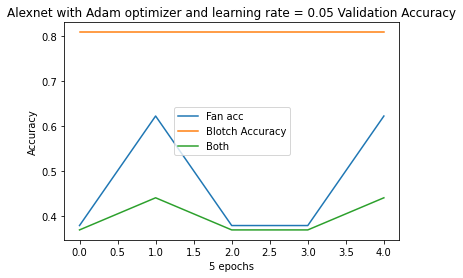

In [39]:
plt.plot(valid_accuracies)
plt.title('Alexnet with Adam optimizer and learning rate = 0.05 Validation Accuracy')
plt.xlabel('5 epochs')
plt.ylabel('Accuracy')
plt.legend(["Fan acc","Blotch Accuracy","Both"])
plt.show()

VGG NETWORK WITH ADAM OPTIMIZER. Lr=0.05

In [ ]:
model = models.vgg16(pretrained=True)
#num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(4096,2)
model.to(device);

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-4)

In [ ]:
avg_train_losses = []
avg_valid_losses = []
valid_accuracies = []


def train_for_epoch(optimizer):
    model.train()

    train_losses = []

    for batch, target in tqdm.tqdm(train_loader):

        # data to GPU
        batch = batch.to(device)
        target = target.to(device)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        predictions = model(batch)
        #breakpoint()

        # calculate loss
        loss = criterion(predictions, target)

        # backward pass
        loss.backward()

        # parameter update
        optimizer.step()

        # track loss
        train_losses.append(float(loss.item()))

    train_losses = np.array(train_losses)
    return train_losses


def validate():
    model.eval()

    valid_losses = []
    y_true, y_prob = [], []

    with torch.no_grad():
        for batch, target in valid_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)
            
            # logits -> probabilities
            torch.sigmoid_(predictions)

            # track losses and predictions
            valid_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_prob.extend(predictions.cpu().numpy())
            
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = y_prob > 0.5
    valid_losses = np.array(valid_losses)

    # calculate validation accuracy from y_true and y_pred
    fan_accuracy = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    blotch_accuracy = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    exact_accuracy = np.all(y_true == y_pred, axis=1).mean()

    # calculate the mean validation loss
    valid_loss = valid_losses.mean()

    return valid_loss, fan_accuracy, blotch_accuracy, exact_accuracy


def train(epochs, first_epoch=1):
    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, fan_accuracy, blotch_accuracy, both_accuracy = validate()
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  ',
              f'fan acc: {fan_accuracy:0.04f}  ',
              f'blotch acc: {blotch_accuracy:0.04f}  ',
              f'both acc: {both_accuracy:0.04f}'
        )
        
        # update learning curves
        avg_train_losses.append(train_loss.mean())
        avg_valid_losses.append(valid_loss)
        valid_accuracies.append((fan_accuracy, blotch_accuracy, both_accuracy))
        
        # save checkpoint
        torch.save(model, f'/content/drive/MyDrive/Models/vgg_adam')

In [ ]:
train(5)

100%|██████████| 752/752 [04:22<00:00,  2.87it/s]


[01] train loss: 1810351920413729280.0000  valid loss: 0.5771   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 752/752 [04:23<00:00,  2.86it/s]


[02] train loss: 27963287622111744.0000  valid loss: 0.5764   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 752/752 [04:25<00:00,  2.84it/s]


[03] train loss: 64942484846823907328.0000  valid loss: 0.5762   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 752/752 [04:25<00:00,  2.84it/s]


[04] train loss: 0.5899  valid loss: 0.5755   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 752/752 [04:25<00:00,  2.83it/s]


[05] train loss: 0.5875  valid loss: 0.5756   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


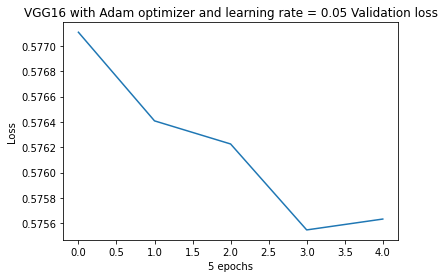

In [ ]:
plt.plot(avg_valid_losses)
plt.title('VGG16 with Adam optimizer and learning rate = 0.05 Validation loss')
plt.xlabel('5 epochs')
plt.ylabel('Loss')
plt.show()

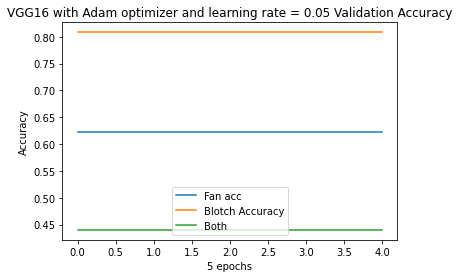

In [ ]:
plt.plot(valid_accuracies)
plt.title('VGG16 with Adam optimizer and learning rate = 0.05 Validation Accuracy')
plt.xlabel('5 epochs')
plt.ylabel('Accuracy')
plt.legend(["Fan acc","Blotch Accuracy","Both"])
plt.show()

VGG with Adam optimizer and Lr=0.001

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
avg_train_losses = []
avg_valid_losses = []
valid_accuracies = []


def train_for_epoch(optimizer):
    model.train()

    train_losses = []

    for batch, target in tqdm.tqdm(train_loader):

        # data to GPU
        batch = batch.to(device)
        target = target.to(device)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        predictions = model(batch)
        #breakpoint()

        # calculate loss
        loss = criterion(predictions, target)

        # backward pass
        loss.backward()

        # parameter update
        optimizer.step()

        # track loss
        train_losses.append(float(loss.item()))

    train_losses = np.array(train_losses)
    return train_losses


def validate():
    model.eval()

    valid_losses = []
    y_true, y_prob = [], []

    with torch.no_grad():
        for batch, target in valid_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)
            
            # logits -> probabilities
            torch.sigmoid_(predictions)

            # track losses and predictions
            valid_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_prob.extend(predictions.cpu().numpy())
            
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = y_prob > 0.5
    valid_losses = np.array(valid_losses)

    # calculate validation accuracy from y_true and y_pred
    fan_accuracy = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    blotch_accuracy = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    exact_accuracy = np.all(y_true == y_pred, axis=1).mean()

    # calculate the mean validation loss
    valid_loss = valid_losses.mean()

    return valid_loss, fan_accuracy, blotch_accuracy, exact_accuracy


def train(epochs, first_epoch=1):
    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, fan_accuracy, blotch_accuracy, both_accuracy = validate()
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  ',
              f'fan acc: {fan_accuracy:0.04f}  ',
              f'blotch acc: {blotch_accuracy:0.04f}  ',
              f'both acc: {both_accuracy:0.04f}'
        )
        
        # update learning curves
        avg_train_losses.append(train_loss.mean())
        avg_valid_losses.append(valid_loss)
        valid_accuracies.append((fan_accuracy, blotch_accuracy, both_accuracy))
        
        # save checkpoint
        torch.save(model, f'/content/drive/MyDrive/Models/adam_0.001')

In [ ]:
train(5)

100%|██████████| 752/752 [04:24<00:00,  2.84it/s]


[01] train loss: 204773681070519517184.0000  valid loss: 23984955856571695104.0000   fan acc: 0.6226   blotch acc: 0.8083   both acc: 0.4407


100%|██████████| 752/752 [04:24<00:00,  2.84it/s]


[02] train loss: 2143624245005926144.0000  valid loss: 0.5755   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 752/752 [04:25<00:00,  2.83it/s]


[03] train loss: 28950228652708597760.0000  valid loss: 0.5765   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


100%|██████████| 752/752 [04:25<00:00,  2.83it/s]


[04] train loss: 65843134140520176.0000  valid loss: 255755827818691.4375   fan acc: 0.3871   blotch acc: 0.8083   both acc: 0.3718


100%|██████████| 752/752 [04:25<00:00,  2.83it/s]


[05] train loss: 2116552881273101056.0000  valid loss: 0.5775   fan acc: 0.6219   blotch acc: 0.8083   both acc: 0.4399


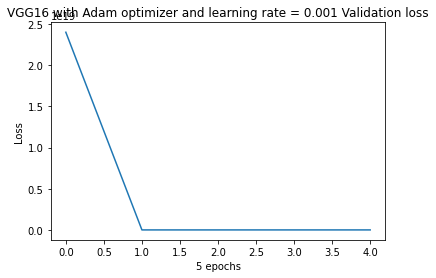

In [ ]:
plt.plot(avg_valid_losses)
plt.title('VGG16 with Adam optimizer and learning rate = 0.001 Validation loss')
plt.xlabel('5 epochs')
plt.ylabel('Loss')
plt.show()

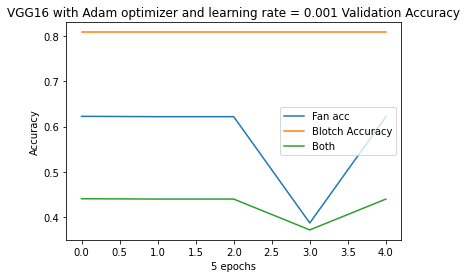

In [ ]:
plt.plot(valid_accuracies)
plt.title('VGG16 with Adam optimizer and learning rate = 0.001 Validation Accuracy')
plt.xlabel('5 epochs')
plt.ylabel('Accuracy')
plt.legend(["Fan acc","Blotch Accuracy","Both"])
plt.show()

Experiment with different data augmentation strategies

In [24]:
test_set = PlanetFourDataset('test', transform=None)

In [25]:
test_loader = DataLoader(test_set, shuffle=False)

In [ ]:
predictions = model(test_set)

In [ ]:
predict_evaluate = model.evaluate(test_set)

In [ ]:
print("Loss on Test Data: ", predict_evaluate[0])

In [ ]:
print('Accuracy on Test Data ', predict_evaluate[1]*100)